# Execise 10: text processing
 - word2vec
 - t-SNE
 - doc2vec


# Word2Vec

In 2013 Mikolov et al. offered an efficient **word2vec** technique for learning word vectors:
 1. get large corpus of text (preferably from the domain that you are interested in)
 2. every word in this text will be part of the vocabulary and it will get its own vector
 3. select a "window" size (we did - 5 words) and go through the text window by window, checking the center word (that would be 3rd word in every context window, like "I have **been** changed in", "have been **changed** in the", "been changed **in** the night"..etc)
 4. calculate the probability of getting a certain context given a certain word or vise versa by comparing the word vectors/embeddings (if we have **changed**,- what is the probability of getting "been","in", etc)
 5. compare the predicted words/contexts to the true ones and keep adjusting the embeddings until you grasp the meaning well enough (maximize the probability of the correct choice, in our case of "been")
 
 N.B. Every word will get a weight a center word and as a context word.
 
 already sounds familiar, right?
 

A word’s meaning is given by the words that frequently appear close-by (distributional semantics).

### Example
The context of a word is the words that appear nearby within a certain window size (let's say 5 words).

 - the quality of *air* in mainland China has been decreasing since..
 - doctors claim the *air* you breath defines the overall wellbeing...
 - the currents of hot *air* have been bursting from underground
 - the mountain *air* was crystal clean and filled with ..
 - in case of *air* supply shortages, the submarine will..

Words around *air* will define the **meaning** of the word for our NN.

![w2vprocess](w2v.jpg)

inspired by https://www.youtube.com/watch?v=BD8wPsr_DAI

### Note on models ###
As said we can go two ways about it:

1. Skip-grams (SG) - we will focus on it

Predict context (”outside”) words  given center word


2. Continuous Bag of Words (CBOW)

Predict center word from (bag of) context words


[? ? **in** ? ?]   VS   [been changed **?** the night]

![w2v architecture](Illustration-of-the-word2vec-models-a-CBOW-b-skip-gram-16-33.png)
Source: https://www.researchgate.net/profile/Elena_Tutubalina/publication/318507923

![sg](https://upload.wikimedia.org/wikipedia/commons/9/95/Skip-gram.png)

Source: https://upload.wikimedia.org/wikipedia/commons/9/95/Skip-gram.png

Mikolov, T., Chen, K., Corrado, G., and Dean, J. (2013). Efficient estimation of word representations in vector space. CoRR, abs/1301.3781.

### How would our NN structure look like for this task (Skip-gram)###

 - input layer has length **V** - the size of our dictionary (how many words is contained in our text corpus), it will be a one-hot encoded vector that 'zeros out' out every word in the dictionary except for the one we are passing as observation
 - we will need to train two weight matrices (**W** and W" - looking ahead, it will be only the W matrix that will contain the word embeddings that we will need). 
 - **N** is our hidden layer, it defines the size of every word embedding
 - **C** is the number of context words (in the past example it was 4)



Another bit that is missing here is the training mechanism - how will we know if the chosen probability is good or bad? We are back to our multiclass problem basically, so we will need good old softmax and cross-entropy loss function (with the amendment that there are tricks to make training efficient - hierarchichal softmax and negative sampling.

### Case

We will look at the social media data: posts of politicians, that are labeled according to the type of message.

Source: https://www.kaggle.com/crowdflower/political-social-media-posts/downloads/political-social-media-posts.zip/1

In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn import model_selection
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

%matplotlib inline

#Setting dataframe max limit of columns in output to 10
pd.set_option('display.max_columns', 10)

#Loading data and printing the columns
data = pd.read_csv("data/political_social_media.csv", encoding = "ISO-8859-1")
print(data.columns)

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'audience', 'audience:confidence', 'bias',
       'bias:confidence', 'message', 'message:confidence', 'orig__golden',
       'audience_gold', 'bias_gold', 'bioid', 'embed', 'id', 'label',
       'message_gold', 'source', 'text'],
      dtype='object')


In [2]:
data=data[["message","message:confidence","label","source","text"]]
data.head(10)
#5000 messages

,message,message:confidence,label,source,text
0,policy,1.0,From: Trey Radel (Representative from Florida),twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,attack,1.0,From: Mitch McConnell (Senator from Kentucky),twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,support,1.0,From: Kurt Schrader (Representative from Oregon),twitter,Please join me today in remembering our fallen...
3,policy,1.0,From: Michael Crapo (Senator from Idaho),twitter,RT @SenatorLeahy: 1st step toward Senate debat...
4,policy,1.0,From: Mark Udall (Senator from Colorado),twitter,.@amazon delivery #drones show need to update ...
5,information,1.0,From: Heidi Heitkamp (Senator from North Dakota),twitter,Called on the @USDOTFRA to release info about ...
6,mobilization,1.0,From: Frederica Wilson (Representative from Fl...,twitter,"@BBCWorld, help us keep the kidnapped Nigerian..."
7,mobilization,1.0,From: Ron Barber (Representative from Arizona),twitter,Show your Arizona pride-choose your favorite S...
8,personal,1.0,From: Chuck Fleischmann (Representative from T...,twitter,What a wonderful night at State Senator Ken Ya...
9,support,1.0,From: Steny Hoyer (Representative from Maryland),twitter,Great op-ed by Pres. Clinton about signing #FM...


In [3]:
import collections
collections.Counter(data["message"])

Counter({'policy': 1411,
         'attack': 172,
         'support': 921,
         'information': 647,
         'mobilization': 129,
         'personal': 1170,
         'other': 121,
         'constituency': 152,
         'media': 277})

In [4]:
c=collections.Counter(data["label"])
print (c.most_common(10))

[('From: Ileana Ros-Lehtinen (Representative from Florida)', 79), ('From: Kevin Brady (Representative from Texas)', 69), ('From: Cory Booker (Senator from New Jersey)', 49), ('From: John Fleming (Representative from Louisiana)', 48), ('From: Bernard Sanders (Senator from Vermont)', 40), ('From: Kyrsten Sinema (Representative from Arizona)', 37), ('From: Todd Rokita (Representative from Indiana)', 35), ('From: Michael Crapo (Senator from Idaho)', 34), ('From: Darrell Issa (Representative from California)', 34), ('From: Niki Tsongas (Representative from Massachusetts)', 33)]


(array([3.500e+01, 3.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 4.959e+03]),
 array([0.502 , 0.5518, 0.6016, 0.6514, 0.7012, 0.751 , 0.8008, 0.8506,
        0.9004, 0.9502, 1.    ]),
 <a list of 10 Patch objects>)

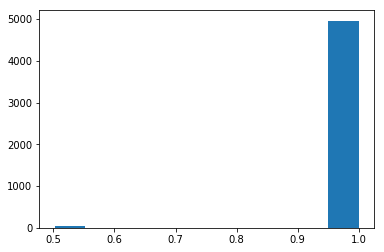

In [5]:
plt.hist(data["message:confidence"])

Seems that we can trust the labels. Let's now look at the text:

In [6]:
raw = list(data.text)
raw[10]
#ok, we will probably have to clean it 

'As POTUS golfs, pushes amnesty &amp; ignores Keystone, American people are concerned about jobs, econ &amp; health care costs http://t.co/p9sPDYOAca'

In [8]:
# word2vec expexts a list of list: each document is a list of tokens
import re
import gensim
prep=[]
for i,line in enumerate(raw):
    # Substitute (read:remove) tokens including https\
    prep.append(gensim.utils.simple_preprocess(re.sub(r'http\S+', '', line)))
prep[10]

['as',
 'potus',
 'golfs',
 'pushes',
 'amnesty',
 'amp',
 'ignores',
 'keystone',
 'american',
 'people',
 'are',
 'concerned',
 'about',
 'jobs',
 'econ',
 'amp',
 'health',
 'care',
 'costs']

In [13]:
#amp is still there
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
stop_words[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [14]:
# Manually add html tags
stop_words.append('amp')
stop_words.append('fl')

In [15]:
# Drop stopwords
prep2=[]
for line in prep:
    prep2.append([word for word in line if word not in stop_words])
print(prep2[10])

['potus', 'golfs', 'pushes', 'amnesty', 'ignores', 'keystone', 'american', 'people', 'concerned', 'jobs', 'econ', 'health', 'care', 'costs']


In [71]:
##### DO NOT RUN: This takes a substantial amount of time #####

from gensim.models import Word2Vec    

# Train a Word2Vec model
model = Word2Vec(prep2, 
                 min_count=1,## min_count means the frequency benchmark, if =2 and word is used only once - it's not included
                 sg=1,#trains CBOW by default, we have to add it to specify for skipgram
                 window=5, #the size of context
                 iter =100, #how many times the training code will run through the data set, same as epochs (first pass is to create dict)
                 size=300, #size of embedding
                 workers=3)#for parallel computing
# summarize the loaded model
print(model)

Word2Vec(vocab=14529, size=300, alpha=0.025)


In [72]:
# summarise vocabulary
words = list(model.wv.vocab)
print(words[5:10])

['slams', 'obamacare', 'politics', 'video', 'full']


In [73]:
model.wv.most_similar("disaster",topn=6)

[('millersburg', 0.5439395904541016),
 ('northampton', 0.535331130027771),
 ('wakeup', 0.5340783596038818),
 ('buildstrongusa', 0.5209213495254517),
 ('klinetth', 0.5162640810012817),
 ('renews', 0.49339860677719116)]

### Visualization: PCA

In [ ]:
from sklearn.decomposition import PCA

# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

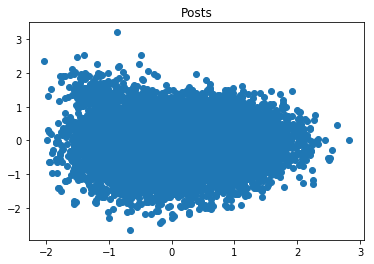

In [74]:
# create a plot of the projection
fig, ax = plt.subplots()
ax.plot(result[:, 0], result[:, 1], 'o')
ax.set_title('Posts')
plt.show()

A drawback of PCA is that it is a linear projection, meaning it can’t capture non-linear dependencies.

### Visualization: t-SNE

The goal is to take a set of points in a high-dimensional space and find a faithful representation of those points in a lower-dimensional space, typically the 2D plane.

An important feature of t-SNE is a tuneable parameter, “perplexity,” which says (loosely) how to balance attention between local and global aspects of your data. The parameter is, in a sense, a guess about the number of close neighbors each point has. The perplexity value has a complex effect on the resulting pictures.

Website by Laurens van der Maaten - the creator of t-SNE (https://lvdmaaten.github.io/tsne/)

Nice explanatory video: https://www.youtube.com/watch?v=NEaUSP4YerM

Or this article: https://distill.pub/2016/misread-tsne/


Step 1: Determine the "similarity" of all points inthe scatterplot. Imagine the point of interest being the center of hte normal distribution curve, all the other points will lie closer of further from it, the closer the lie, the higher the similarity. We will then scale those similarities to account for the density of clusters. t-SNE will have a perplexity parameter that reflects the expected density around each point.

Step 2: We end up with a matrix of similarity scores between all the points. We then try to project the observation on the 1-dimensional space and perform the same procedure - measuring the similarity but through a t-distribution (Student distribution). We then compare the two similarity matrices. Obviously the second one is much further from the truth. t-SNE will make little steps to move the observations around on the projected line so as the matrix of true similarities is as close to the 'true' one as possible. When implementes with code, it is performed using stochastic gradient descent. The loss function is based on the distances between points ($y_i$ and $y_j$) and probability distributions over those distances ($p_{ij}$ and $q_{ij}$)

In stricter terms t-SNE converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. 

Two important points:

 - t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.


 - you can not make any conclusions on the distances: how big is the cluster, how far clusters are from each other, etc. The axises of t-SNE visualization are not interpretable

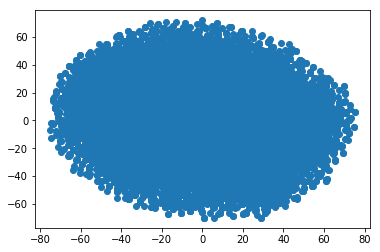

In [31]:
#do not run

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50) #perplexity=30 by default, suggested values are between 6 and 60, the denser your data is, the hogher perplexity you might want
Y = tsne.fit_transform(X[1000:])

plt.scatter(Y[:, 0], Y[:, 1])
plt.show()

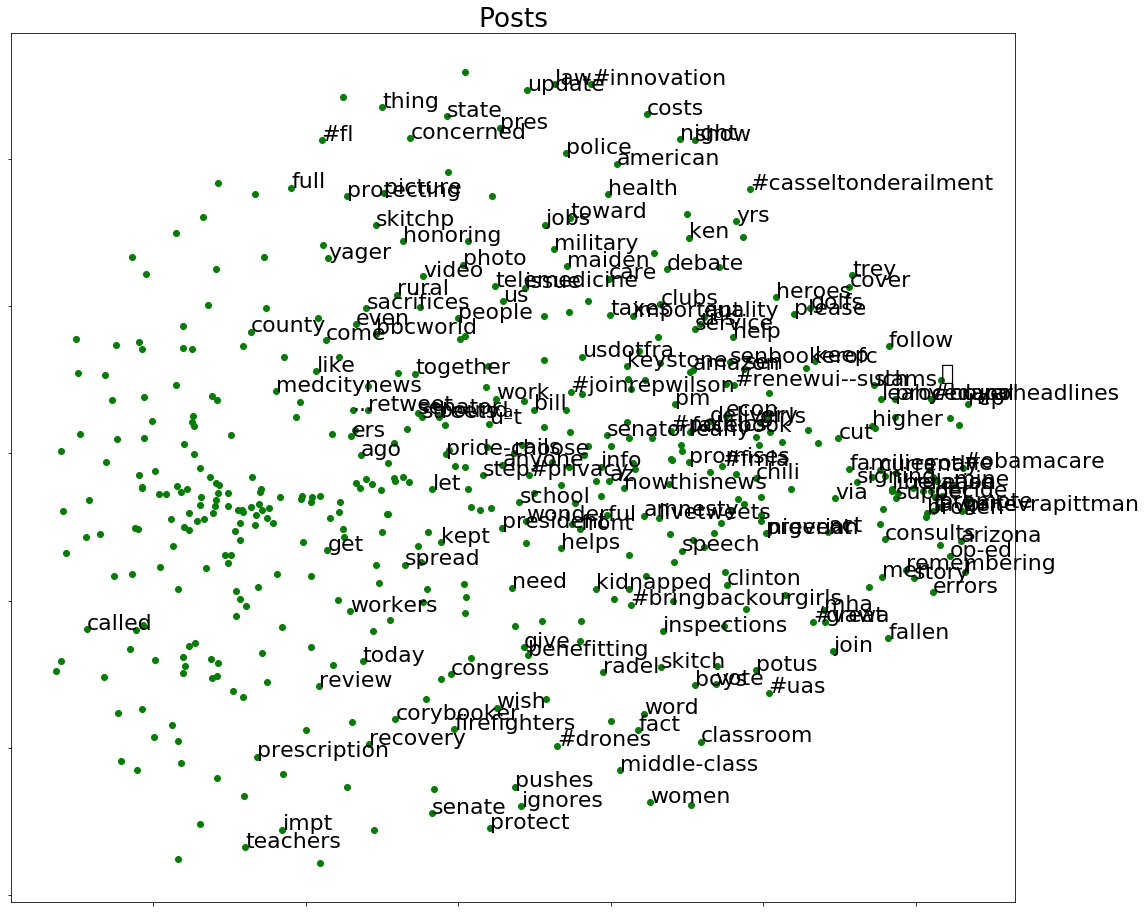

<Figure size 432x288 with 0 Axes>

In [60]:

fig, ax = plt.subplots(figsize=(18, 16))
plt.rcParams.update({'font.size': 22})
ax.plot(Y[:, 0], Y[:, 1], 'o',color='green')
ax.set_title('Posts')
ax.set_yticklabels([]) #Hide ticks
ax.set_xticklabels([]) #Hide ticks


words = list(model.wv.vocab)
for i, word in enumerate(words[1:180]):
    plt.annotate(word, xy=(Y[i, 0], Y[i, 1]))
plt.show()
plt.savefig('w2v.png')

## doc2vec
The main difference is: instead of supplying a word, we supply a document id. doc2vec also has two models: PV-DM (extension of DBOW) that keeps the order and PV-DBOW (analogue of SkipGram), that unlike PV-DM does not store the word vectors. Very popular for information retrieval (I have this text, find me similair) and sentiment analysis (i.e. would you label this post as "angry" or "sad").

**PV-DBOW**: given the document (paragraph/sentence) id, predict the context (order of context is not preserved)

![pvdbow](https://humboldt-wi.github.io/blog/img/seminar/topic_models/pvdbow.png)

**PV-DM**: given the document (paragraph/sentence) id and several ordered context words, predict one

![pvdm](https://2.bp.blogspot.com/-IpnvLkBHx74/WdnUJ5r3q_I/AAAAAAAAnxI/Cz9B_YQo6tcu0YwOffsQQWmcfjH_mRulwCK4BGAYYCw/w1200-h630-p-k-no-nu/pv_dm.png)

For some additional info:
https://rare-technologies.com/doc2vec-tutorial/

For efficiency:

In [ ]:
#to speed things up
import multiprocessing
cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1


For processing we will try smth new:

In [75]:
import string
from nltk.tokenize.casual import TweetTokenizer

stopword_set = set(stopwords.words('english'))
tokenizer = TweetTokenizer
#MessageDoc = namedtuple('MessageDoc', 'words tags')

d2v=pd.DataFrame({'post': data.text, 'label': data.label,'mood':data.message})
d2v=d2v.reset_index(drop=True)
d2v.head(10)

,post,label,mood
0,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,From: Trey Radel (Representative from Florida),policy
1,VIDEO - #Obamacare: Full of Higher Costs and ...,From: Mitch McConnell (Senator from Kentucky),attack
2,Please join me today in remembering our fallen...,From: Kurt Schrader (Representative from Oregon),support
3,RT @SenatorLeahy: 1st step toward Senate debat...,From: Michael Crapo (Senator from Idaho),policy
4,.@amazon delivery #drones show need to update ...,From: Mark Udall (Senator from Colorado),policy
5,Called on the @USDOTFRA to release info about ...,From: Heidi Heitkamp (Senator from North Dakota),information
6,"@BBCWorld, help us keep the kidnapped Nigerian...",From: Frederica Wilson (Representative from Fl...,mobilization
7,Show your Arizona pride-choose your favorite S...,From: Ron Barber (Representative from Arizona),mobilization
8,What a wonderful night at State Senator Ken Ya...,From: Chuck Fleischmann (Representative from T...,personal
9,Great op-ed by Pres. Clinton about signing #FM...,From: Steny Hoyer (Representative from Maryland),support


In [76]:
position=[]
for row in d2v["label"]:
    position.append(row[row.find("(")+1:row.find(" from")])
d2v["position"]=position


In [77]:
d2v.head(10)

,post,label,mood,position
0,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,From: Trey Radel (Representative from Florida),policy,Representative
1,VIDEO - #Obamacare: Full of Higher Costs and ...,From: Mitch McConnell (Senator from Kentucky),attack,Senator
2,Please join me today in remembering our fallen...,From: Kurt Schrader (Representative from Oregon),support,Representative
3,RT @SenatorLeahy: 1st step toward Senate debat...,From: Michael Crapo (Senator from Idaho),policy,Senator
4,.@amazon delivery #drones show need to update ...,From: Mark Udall (Senator from Colorado),policy,Senator
5,Called on the @USDOTFRA to release info about ...,From: Heidi Heitkamp (Senator from North Dakota),information,Senator
6,"@BBCWorld, help us keep the kidnapped Nigerian...",From: Frederica Wilson (Representative from Fl...,mobilization,Representative
7,Show your Arizona pride-choose your favorite S...,From: Ron Barber (Representative from Arizona),mobilization,Representative
8,What a wonderful night at State Senator Ken Ya...,From: Chuck Fleischmann (Representative from T...,personal,Representative
9,Great op-ed by Pres. Clinton about signing #FM...,From: Steny Hoyer (Representative from Maryland),support,Representative


We will need to prepared an object that contains two lists: the label list and the corresponding list of lists with tokens.

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

alldocs = []  # Will hold all doacs in original order
for index,row in d2v.iterrows():
    message = row['post'].lower()
    message = tokenizer().tokenize(message) 
    #import pdb; pdb.set_trace()
    words = [word.strip('@') for word in message if (word not in stopword_set 
                                          and word not in string.punctuation
                                          and not word.startswith('http')
                                          and not re.search(r'\d', word))]
    tags = [row['label']] 
    
    alldocs.append(TaggedDocument(words, tags))

In [78]:
alldocs[10]

TaggedDocument(words=['potus', 'golfs', 'pushes', 'amnesty', 'ignores', 'keystone', 'american', 'people', 'concerned', 'jobs', 'econ', 'health', 'care', 'costs'], tags=['From: John Fleming (Representative from Louisiana)'])

The algorithm will run through the corpus **twice**: once to build the vocab, and once to train the model on the input data, learning a vector representation for each word and for each label in the dataset.

In [82]:
epochs = 50
emb = 200 # how long do we want the embedding layer ot be
alpha = 0.01 # learning rate

In [83]:
#do not run

#Mind again - it's not Keras, so slightly different 'grammar'
model = Doc2Vec(vector_size=emb,
                min_count=1, # if the word is seen only once, it is thrown out
                dm =1,#  dm=1 means ‘distributed memory’ (PV-DM), and dm =0 means ‘distributed bag of words’ (PV-DBOW).
#dm model preserves the word order in a document whereas dbow scrambles it
                train_words=True,# train only for labels or also words
                alpha=alpha, min_alpha=0.0025) # for these models learning rate is named alpha
  
model.build_vocab(alldocs)

for epoch in range(epochs):
    print('iteration {0}'.format(epoch))
    model.train(alldocs,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.002
    
    
model.save("d2v.model")
print("Model Saved")

iteration 0


C:\Users\AlisaK\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49


C:\Users\AlisaK\AppData\Local\Continuum\anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Model Saved


In [ ]:
#model= Doc2Vec.load('d2v.model')

In [84]:
print(model.docvecs['From: Jeff Sessions (Senator from Alabama)'])

[ 0.07323372 -1.0458966  -0.3650489  -0.02238957 -0.2134557   0.9197289
 -2.4259      0.72180533 -0.5403568   0.6087173   1.2815129  -0.44964272
  0.19259736  0.9028988   1.2639016  -0.6334379   0.66378385  0.07038835
  1.1085382  -0.24865265  0.6256733  -0.7752401   0.617929    2.0802212
  0.9437239   1.3143232   0.3459126   0.7494442  -0.5599254  -0.52608114
  1.1238263  -0.33878827  0.69430065 -0.46032897  0.43663064 -0.27662247
 -0.57273537  0.67068535 -0.6172461   1.110707    1.395668    1.0276914
 -1.7143548   0.4781022   0.10355343 -0.72389483  1.0834153   0.22834453
 -0.71624905  0.15370652  0.50156695 -0.31133306 -0.5899333  -0.7527683
  0.5802598   0.847867    0.07446347  1.3126239  -1.5410237   0.973512
 -1.3171952   0.21095774  0.19930853  0.12384523  0.97021395  0.6934399
  1.8111649   0.36602062 -0.8643943   0.5741724  -1.3881459   0.9899576
 -1.2102706  -1.371078    0.12532307  0.6584583   0.10080215  0.05229804
 -0.21146892 -0.24240911 -0.35794237  0.9301031  -0.6514732

In [85]:
similar_doc = model.docvecs.most_similar('From: Jeff Sessions (Senator from Alabama)')
print(similar_doc)

[('From: Morgan Griffith (Representative from Virginia)', 0.7391694188117981), ('From: Jeff Miller (Representative from Florida)', 0.7321223616600037), ('From: Ted Deutch (Representative from Florida)', 0.7227764129638672), ('From: Tim Kaine (Senator from Virginia)', 0.7113656997680664), ('From: John Yarmuth (Representative from Kentucky)', 0.7019100189208984), ('From: Richard Shelby (Senator from Alabama)', 0.693526566028595), ('From: Cynthia Lummis (Representative from Wyoming)', 0.689687192440033), ('From: Mike Doyle (Representative from Pennsylvania)', 0.6873407363891602), ('From: Jim McDermott (Representative from Washington)', 0.6843476295471191), ('From: Rob Woodall (Representative from Georgia)', 0.6760823726654053)]


In [86]:
mask = [tag in d2v['label'].values for tag in model.docvecs.offset2doctag]
X = model.docvecs.vectors_docs[mask]
X

array([[ 0.8350104 , -0.43078208, -0.07886539, ..., -0.07909209,
        -0.68595386, -0.11320835],
       [ 2.5681667 ,  0.9916213 , -1.0272545 , ..., -1.3737926 ,
        -6.3520856 , -0.69449383],
       [-0.45252743, -1.3167044 , -0.23049223, ..., -0.709504  ,
        -3.316392  ,  0.6917256 ],
       ...,
       [ 0.22816974, -0.09967939,  0.05825617, ...,  0.10566043,
         0.93908113, -0.39220482],
       [-0.00894878, -0.9454651 , -0.55608994, ...,  1.4250199 ,
         1.0028845 ,  0.18530563],
       [-0.05085925,  0.17939353,  0.0638466 , ...,  0.682378  ,
         0.81439203,  0.36467633]], dtype=float32)

In [90]:
tsne = TSNE(n_components=2, perplexity=100)#play around
Y = tsne.fit_transform(X)

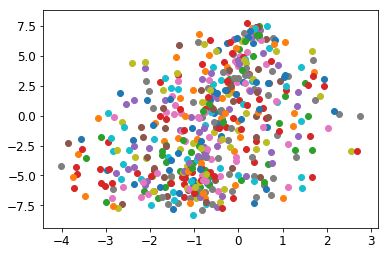

In [92]:
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 12})

groups = pd.DataFrame(Y, columns=['x', 'y']).assign(category=d2v["label"]).groupby('category')
for name, points in groups:
    ax.scatter(points.x, points.y, label=name)

#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
#          ncol=3, fancybox=True, shadow=True)
#plt.savefig('d2v.png')

## Bibliography 
Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space. International Conference on Learning Representations Workshop, abs/1301.3781.

Mikolov,  T., Sutskever, I., Chen, K., Corrado, G., & Dean, J. (2013). Distributed Representations of Words and Phrases and their Compositionality. Proceedings of the 26th International Conference on Neural Information Processing Systems, 3111–3119.

